In [18]:
import sys
sys.path.append("../")
from broncode.apple_classifyer import AppleClassifyer

In [3]:
import torchvision.transforms as T
from torch.utils.data import Subset, Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional
from torchvision.datasets import ImageFolder
from torchvision.io import read_image, ImageReadMode
import torch
import pickle as pkl
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os



In [4]:
path = "../informatie/apple_disease_classification/images/Train/Dataset/normal_apples/good_apple0.jpg"
img = read_image(path, ImageReadMode.UNCHANGED)/255

print(img.shape)
print(img)

torch.Size([3, 128, 128])
tensor([[[0.9059, 0.9059, 0.9059,  ..., 0.9294, 0.9294, 0.9294],
         [0.9059, 0.9059, 0.9059,  ..., 0.9294, 0.9294, 0.9294],
         [0.9059, 0.9059, 0.9059,  ..., 0.9294, 0.9294, 0.9294],
         ...,
         [0.9490, 0.9490, 0.9490,  ..., 0.9725, 0.9725, 0.9725],
         [0.9529, 0.9529, 0.9529,  ..., 0.9725, 0.9725, 0.9725],
         [0.9529, 0.9529, 0.9529,  ..., 0.9725, 0.9725, 0.9725]],

        [[0.9216, 0.9216, 0.9216,  ..., 0.9294, 0.9294, 0.9294],
         [0.9216, 0.9216, 0.9216,  ..., 0.9294, 0.9294, 0.9294],
         [0.9216, 0.9216, 0.9216,  ..., 0.9294, 0.9294, 0.9294],
         ...,
         [0.9412, 0.9412, 0.9412,  ..., 0.9529, 0.9529, 0.9529],
         [0.9451, 0.9451, 0.9451,  ..., 0.9529, 0.9529, 0.9529],
         [0.9451, 0.9451, 0.9451,  ..., 0.9529, 0.9529, 0.9529]],

        [[0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
         [0.9569, 0.9569, 0.9569,  ..., 0.9686, 0.9686, 0.9686],
         [0.9569, 0.9569, 0.9569

In [5]:

dataset_path = "../informatie/apple_disease_classification/images/Train/Dataset/"

In [6]:
class DatasetAppels(Dataset):
    def __init__(self, img_folder_path, transform):

        image_folder = ImageFolder(img_folder_path, transform=transform)
        print(image_folder.classes)
        self.images = [image[0] for image in image_folder]
        self.labels = image_folder.targets
        self.class_dict = image_folder.class_to_idx

    def labeler(self, label, len_classes):
        result = [0] * len_classes
        result[label] = 1
        return result

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
    
        return [self.images[idx], self.labels[idx]]
    


In [7]:
dataset = DatasetAppels(dataset_path, T.ToTensor())

next(iter(dataset))


['blotch_apples', 'normal_apples', 'rot_apples', 'scab_apples']


[tensor([[[0.6745, 0.6863, 0.7059,  ..., 0.6824, 0.6902, 0.6980],
          [0.6784, 0.6902, 0.7098,  ..., 0.6902, 0.6902, 0.6941],
          [0.6863, 0.7020, 0.7137,  ..., 0.7020, 0.6941, 0.6902],
          ...,
          [0.6235, 0.6275, 0.6314,  ..., 0.0275, 0.0235, 0.0863],
          [0.6275, 0.6353, 0.6431,  ..., 0.0353, 0.0039, 0.0039],
          [0.6275, 0.6353, 0.6431,  ..., 0.1059, 0.0392, 0.1137]],
 
         [[0.5490, 0.5608, 0.5804,  ..., 0.5725, 0.5804, 0.5882],
          [0.5529, 0.5647, 0.5843,  ..., 0.5804, 0.5804, 0.5843],
          [0.5608, 0.5765, 0.5882,  ..., 0.5922, 0.5843, 0.5804],
          ...,
          [0.4863, 0.4902, 0.4863,  ..., 0.0118, 0.0000, 0.0588],
          [0.4902, 0.4980, 0.4980,  ..., 0.0314, 0.0000, 0.0000],
          [0.4902, 0.4980, 0.4980,  ..., 0.1098, 0.0314, 0.1020]],
 
         [[0.4510, 0.4627, 0.4824,  ..., 0.4784, 0.4863, 0.4941],
          [0.4549, 0.4667, 0.4863,  ..., 0.4863, 0.4863, 0.4902],
          [0.4627, 0.4784, 0.4902,  ...,

In [8]:
print(dataset.class_dict)

{'blotch_apples': 0, 'normal_apples': 1, 'rot_apples': 2, 'scab_apples': 3}


In [9]:
resize_data = T.Resize((64,64))
print(dataset.images[0])

for i in range(len(dataset.images)):
    dataset.images[i] = resize_data(dataset.images[i])

print(dataset.images[0])

tensor([[[0.6745, 0.6863, 0.7059,  ..., 0.6824, 0.6902, 0.6980],
         [0.6784, 0.6902, 0.7098,  ..., 0.6902, 0.6902, 0.6941],
         [0.6863, 0.7020, 0.7137,  ..., 0.7020, 0.6941, 0.6902],
         ...,
         [0.6235, 0.6275, 0.6314,  ..., 0.0275, 0.0235, 0.0863],
         [0.6275, 0.6353, 0.6431,  ..., 0.0353, 0.0039, 0.0039],
         [0.6275, 0.6353, 0.6431,  ..., 0.1059, 0.0392, 0.1137]],

        [[0.5490, 0.5608, 0.5804,  ..., 0.5725, 0.5804, 0.5882],
         [0.5529, 0.5647, 0.5843,  ..., 0.5804, 0.5804, 0.5843],
         [0.5608, 0.5765, 0.5882,  ..., 0.5922, 0.5843, 0.5804],
         ...,
         [0.4863, 0.4902, 0.4863,  ..., 0.0118, 0.0000, 0.0588],
         [0.4902, 0.4980, 0.4980,  ..., 0.0314, 0.0000, 0.0000],
         [0.4902, 0.4980, 0.4980,  ..., 0.1098, 0.0314, 0.1020]],

        [[0.4510, 0.4627, 0.4824,  ..., 0.4784, 0.4863, 0.4941],
         [0.4549, 0.4667, 0.4863,  ..., 0.4863, 0.4863, 0.4902],
         [0.4627, 0.4784, 0.4902,  ..., 0.4980, 0.4902, 0.

C:\Users\nilsm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[0.6824, 0.7118, 0.7157,  ..., 0.7127, 0.6912, 0.6931],
         [0.6990, 0.7206, 0.7235,  ..., 0.7059, 0.7088, 0.6922],
         [0.7118, 0.7255, 0.7245,  ..., 0.7108, 0.7137, 0.6990],
         ...,
         [0.6392, 0.6461, 0.6549,  ..., 0.0578, 0.0873, 0.0765],
         [0.6216, 0.6265, 0.6275,  ..., 0.0382, 0.0343, 0.0441],
         [0.6314, 0.6392, 0.6294,  ..., 0.0422, 0.0490, 0.0402]],

        [[0.5569, 0.5863, 0.5902,  ..., 0.6029, 0.5814, 0.5833],
         [0.5735, 0.5951, 0.5980,  ..., 0.5961, 0.5990, 0.5824],
         [0.5863, 0.6000, 0.5990,  ..., 0.6010, 0.6039, 0.5892],
         ...,
         [0.5020, 0.5010, 0.4980,  ..., 0.0167, 0.0275, 0.0020],
         [0.4843, 0.4814, 0.4745,  ..., 0.0284, 0.0118, 0.0147],
         [0.4941, 0.4941, 0.4765,  ..., 0.0578, 0.0500, 0.0333]],

        [[0.4588, 0.4882, 0.4922,  ..., 0.5088, 0.4873, 0.4892],
         [0.4755, 0.4971, 0.5000,  ..., 0.5020, 0.5049, 0.4882],
         [0.4882, 0.5020, 0.5010,  ..., 0.5069, 0.5098, 0.

In [10]:
generator1 = torch.Generator().manual_seed(13)

# create a train test split with 60% train, 20% test, 20% val. For later use
train_dataset, test_dataset, val_dataset = random_split(dataset, [0.6, 0.2, 0.2], generator=generator1)

# Print length of the splits to doublecheck.
print(len(train_dataset), len(test_dataset), len(val_dataset))

# Create train, test and val dataloaders for later use.
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

875 291 291


epoch: 1
tensor(7.7009, device='cuda:0')
epoch: 2
tensor(7.2383, device='cuda:0')
epoch: 3
tensor(7.1129, device='cuda:0')
epoch: 4
tensor(7.0880, device='cuda:0')
epoch: 5
tensor(6.7015, device='cuda:0')
epoch: 6
tensor(6.4359, device='cuda:0')
epoch: 7
tensor(6.2785, device='cuda:0')
epoch: 8
tensor(6.0887, device='cuda:0')
epoch: 9
tensor(5.9789, device='cuda:0')
epoch: 10
tensor(5.8903, device='cuda:0')
epoch: 11
tensor(6.1979, device='cuda:0')
epoch: 12
tensor(5.7917, device='cuda:0')
epoch: 13
tensor(5.8342, device='cuda:0')
epoch: 14
tensor(5.9459, device='cuda:0')
epoch: 15
tensor(5.8516, device='cuda:0')
epoch: 16
tensor(6.1121, device='cuda:0')
epoch: 17
tensor(5.8151, device='cuda:0')
epoch: 18
tensor(5.6887, device='cuda:0')
epoch: 19
tensor(5.7671, device='cuda:0')
epoch: 20
tensor(5.8296, device='cuda:0')
epoch: 21
tensor(5.7751, device='cuda:0')
epoch: 22
tensor(5.6327, device='cuda:0')
epoch: 23
tensor(5.7425, device='cuda:0')
epoch: 24
tensor(5.8289, device='cuda:0')
e

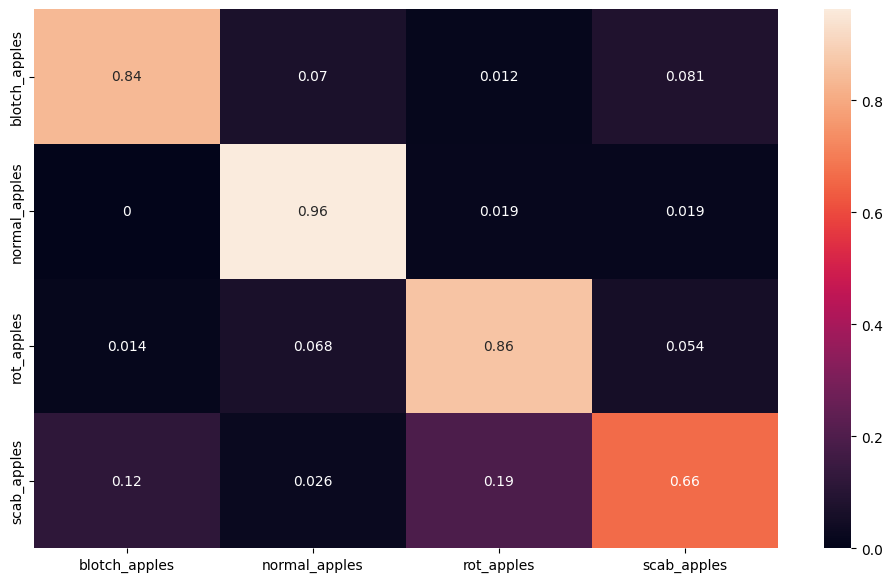

Accuracy: 82


([tensor(7.7009, device='cuda:0'),
  tensor(7.2383, device='cuda:0'),
  tensor(7.1129, device='cuda:0'),
  tensor(7.0880, device='cuda:0'),
  tensor(6.7015, device='cuda:0'),
  tensor(6.4359, device='cuda:0'),
  tensor(6.2785, device='cuda:0'),
  tensor(6.0887, device='cuda:0'),
  tensor(5.9789, device='cuda:0'),
  tensor(5.8903, device='cuda:0'),
  tensor(6.1979, device='cuda:0'),
  tensor(5.7917, device='cuda:0'),
  tensor(5.8342, device='cuda:0'),
  tensor(5.9459, device='cuda:0'),
  tensor(5.8516, device='cuda:0'),
  tensor(6.1121, device='cuda:0'),
  tensor(5.8151, device='cuda:0'),
  tensor(5.6887, device='cuda:0'),
  tensor(5.7671, device='cuda:0'),
  tensor(5.8296, device='cuda:0'),
  tensor(5.7751, device='cuda:0'),
  tensor(5.6327, device='cuda:0'),
  tensor(5.7425, device='cuda:0'),
  tensor(5.8289, device='cuda:0'),
  tensor(5.7918, device='cuda:0'),
  tensor(5.9010, device='cuda:0'),
  tensor(5.7938, device='cuda:0'),
  tensor(5.8001, device='cuda:0'),
  tensor(5.6016, dev

In [12]:
net = AppleClassifyer()

net.fit(train_loader, val_loader, test_loader, lr = 0.0015, epochs=80)

In [13]:
# model_path = "..//models/CNN_86"

# with open(model_path, 'wb') as f:
#         pkl.dump(net, f)

In [14]:
# load = open(model_path, "rb")
# loaded_net = pkl.load(load)

normal = [9,10,11,21,22]

for i in normal:
    test_path = f"../informatie/apple_disease_classification/images/Test/Normal_Apple/{i}.jpg"
    test_img = read_image(test_path, ImageReadMode.RGB)/255

    test_img = resize_data(test_img)
    test_img = test_img.unsqueeze(0)
    result = net.predict_image(test_img)
    print(result)
    

tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')


C:\Users\nilsm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [15]:
aql_sample20 = []
aql_path = "../informatie/apple_disease_classification/images/Test/AQL_testbatch/"

for filename in os.listdir(aql_path):
    aql_sample20.append(read_image(aql_path+filename, ImageReadMode.RGB)/255)

print(aql_sample20)

[tensor([[[0.4471, 0.4627, 0.4784,  ..., 0.3961, 0.3725, 0.3569],
         [0.4510, 0.4588, 0.4706,  ..., 0.4118, 0.3804, 0.3608],
         [0.4549, 0.4588, 0.4667,  ..., 0.4196, 0.3882, 0.3647],
         ...,
         [0.4784, 0.4431, 0.3922,  ..., 0.3843, 0.3804, 0.3765],
         [0.4471, 0.4157, 0.3765,  ..., 0.3725, 0.3804, 0.3843],
         [0.4235, 0.3961, 0.3686,  ..., 0.3608, 0.3765, 0.3882]],

        [[0.4196, 0.4353, 0.4510,  ..., 0.4078, 0.3843, 0.3686],
         [0.4235, 0.4314, 0.4431,  ..., 0.4235, 0.3922, 0.3725],
         [0.4275, 0.4314, 0.4392,  ..., 0.4314, 0.4000, 0.3765],
         ...,
         [0.4627, 0.4275, 0.3765,  ..., 0.3922, 0.3882, 0.3843],
         [0.4314, 0.4000, 0.3608,  ..., 0.3804, 0.3882, 0.3922],
         [0.4078, 0.3804, 0.3529,  ..., 0.3686, 0.3843, 0.3961]],

        [[0.3882, 0.4039, 0.4196,  ..., 0.3804, 0.3569, 0.3412],
         [0.3922, 0.4000, 0.4118,  ..., 0.3961, 0.3647, 0.3451],
         [0.3961, 0.4000, 0.4078,  ..., 0.4039, 0.3725, 0

In [16]:
resize = T.Resize((64,64))
print(aql_sample20[0].shape)

for i in range(len(aql_sample20)):
    aql_sample20[i] = resize(aql_sample20[i])
    aql_sample20[i] = aql_sample20[i].unsqueeze(0)

    print(aql_sample20[0].shape)

torch.Size([3, 312, 251])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


In [17]:
aql, good_amount = net.aql_classifyer(aql_sample20)

print(good_amount)
print(f"AQL quality from code letter F: {aql}")

Good: 12/20
AQL quality from code letter F: 15
